Image shape:  (1, 256, 256, 1)


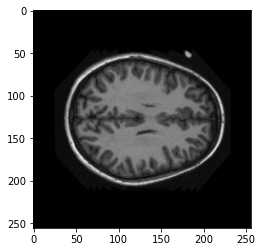

In [6]:
import tensorflow as tf
import numpy as np
import PIL
from PIL import Image
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

#Define key parameters
batch_size = 50
image_height = 256
image_width = 256
channels = 1 # images are in grayscale
epochs = 200
latent_dims = 32
depth = 32

def create_image(data):
    #Creates a 3D image with extra grayscale channel added
    #4D tensor now
    image = tf.io.decode_png(data, channels=1)
    #normalise the image - float values between 0 and 1
    image = image / 255
    #resize image to 256 x 256
    return tf.image.resize(image, [image_height, image_width], antialias = True)

def get_image_from_file(path):
    #Extract file contents
    raw_data = tf.io.read_file(path)
    image = create_image(raw_data)
    return image

def set_dataset_parameters(dataset):
    # Make sure the dataset is in batches, well-shuffled and prefetches the information
    dataset = dataset.cache().shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

def create_train_test_dataset(path_to_training_folder, path_to_test_folder):
    
    # Example path = 'H:\keras_png_slices_data\keras_png_slices_train\*'
    # Example training test_dir path = 'H:\keras_png_slices_data\keras_png_slices_test\*'
    
    # Create the training and testing datasets from the list of files
    training_files = tf.data.Dataset.list_files(path_to_training_folder, shuffle=False)
    test_files = tf.data.Dataset.list_files(path_to_test_folder, shuffle=False)

    #Retreive the size of each dataset
    num_train_images = training_files.cardinality().numpy()
    num_test_images = test_files.cardinality().numpy()
        
    # Shuffle the files
    training_files = training_files.shuffle(num_train_images, reshuffle_each_iteration=True)
    test_files = test_files.shuffle(num_test_images, reshuffle_each_iteration=True)

    # Map the filenames to images inside each dataset
    x_train = training_files.map(get_image_from_file, num_parallel_calls=tf.data.AUTOTUNE)
    x_test = test_files.map(get_image_from_file, num_parallel_calls=tf.data.AUTOTUNE)

    # Finalise data set configurations
    x_train = set_dataset_parameters(x_train)
    x_test2 = x_test.cache().prefetch(buffer_size=tf.data.AUTOTUNE).batch(544)
    x_test = set_dataset_parameters(x_test)   
    
    #Return the datasets
    return x_train, x_test, x_test2


training_ds, testing_ds_unbatched, testing_ds_batched = create_train_test_dataset('H:\keras_png_slices_data\keras_png_slices_train\*','H:\keras_png_slices_data\keras_png_slices_test\*')

#Check the dataset was created correctly
example_batch = training_ds.take(1)
ex_image = 0
for element in example_batch:
    for image in element:
        ex_image = image[tf.newaxis, :]
        break
    break

print("Image shape: ", ex_image.numpy().shape)
plt.imshow(ex_image[0, :, :, 0], cmap='gray')
